In [1]:
import argparse
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import zipfile

from sklearn.metrics import (accuracy_score, classification_report,confusion_matrix)
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import (AveragePooling2D, Dense, Dropout, Flatten, Input, MaxPooling2D)
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import (ImageDataGenerator,img_to_array, load_img)
from tensorflow.keras.utils import to_categorical

In [2]:
from utils import *
%load_ext autoreload
%autoreload 2

In [3]:
zipf = zipfile.ZipFile('/content/drive/My Drive/Others/Blood_noblood.zip','r')
zipf.extractall('/content/')
zipf.close()

### Getting ready with Images

In [5]:
data_dir = 'Data/Redonly'#_processed'
blood_dir = os.path.join(data_dir, 'blood')
noblood_dir = os.path.join(data_dir, 'noblood')

In [6]:
df_blood = pd.DataFrame({'files': getFiles(blood_dir), 'labels': '1'})
df_noblood = pd.DataFrame({'files': getFiles(noblood_dir), 'labels': '0'})

corrupted_blood = getCorrupted(df_blood)
corrupted_noblood = getCorrupted(df_noblood)

corrupted_blood = []
corrupted_noblood = ['Data/Blood_noblood\\noblood\\noblood_111.jpg', 'Data/Blood_noblood\\noblood\\noblood_115.jpg', 'Data/Blood_noblood\\noblood\\noblood_123.jpg', 'Data/Blood_noblood\\noblood\\noblood_16.jpg', 'Data/Blood_noblood\\noblood\\noblood_208.jpg', 'Data/Blood_noblood\\noblood\\noblood_240.jpg', 'Data/Blood_noblood\\noblood\\noblood_305.jpg', 'Data/Blood_noblood\\noblood\\noblood_336.jpg', 'Data/Blood_noblood\\noblood\\noblood_68.jpg']

df_blood = removeCorrupted(df_blood, corrupted_blood)
df_noblood = removeCorrupted(df_noblood, corrupted_noblood)

In [7]:
df = pd.concat([df_blood, df_noblood])
df.reset_index(drop=True, inplace=True)
df.head()

,files,labels
0,Data/Redonly\blood\0_blood_0.jpg,1
1,Data/Redonly\blood\0_blood_10.jpg,1
2,Data/Redonly\blood\0_blood_100.jpg,1
3,Data/Redonly\blood\0_blood_101.jpg,1
4,Data/Redonly\blood\0_blood_102.jpg,1


In [1]:
# images size
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_CHANNELS=3
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_SHAPE=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)

In [9]:
# splitting data
train_df, val_df = train_test_split(df, test_size=0.20, random_state=123)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

size_train = train_df.shape[0]
size_val = val_df.shape[0]
BATCH_SIZE = 32

### Image Augmentation

In [10]:
# initialising the data generators (Image Augmentation)
train_datagen = ImageDataGenerator(
    rotation_range=20,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.25,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='files',
    y_col='labels',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    val_df, 
    x_col='files',
    y_col='labels',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 874 validated image filenames belonging to 2 classes.
Found 219 validated image filenames belonging to 2 classes.


### Initializing the Model (Transfer Learning)

In [11]:
base = MobileNetV2(input_tensor=Input(shape=(224, 224, 3)), weights="imagenet", include_top=False)

C:\ProgramData\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [12]:
model = Sequential()
model.add(base)
model.add(MaxPooling2D(pool_size=(5, 5)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(1, activation="sigmoid"))

base.trainable = False
          
optimizer = Adam(lr=1e-4)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 1, 1280)        0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

### Training

In [15]:
EPOCHS = 10 #10 20
history = model.fit(
            train_generator,
            steps_per_epoch=size_val // BATCH_SIZE,
            validation_data = validation_generator,
            epochs = EPOCHS,
            validation_steps=size_val // BATCH_SIZE,
            verbose=2)

Train for 6 steps, validate for 6 steps
Epoch 1/10
6/6 - 33s - loss: 0.6723 - accuracy: 0.7135 - val_loss: 0.6653 - val_accuracy: 0.6823
Epoch 2/10
6/6 - 24s - loss: 0.7325 - accuracy: 0.6302 - val_loss: 0.6589 - val_accuracy: 0.6719
Epoch 3/10
6/6 - 23s - loss: 0.7582 - accuracy: 0.6094 - val_loss: 0.6405 - val_accuracy: 0.6823
Epoch 4/10
6/6 - 23s - loss: 0.6337 - accuracy: 0.6927 - val_loss: 0.6424 - val_accuracy: 0.6719
Epoch 5/10
6/6 - 23s - loss: 0.6396 - accuracy: 0.6198 - val_loss: 0.6501 - val_accuracy: 0.6667
Epoch 6/10
6/6 - 23s - loss: 0.7009 - accuracy: 0.6823 - val_loss: 0.6791 - val_accuracy: 0.6562
Epoch 7/10
6/6 - 23s - loss: 0.6438 - accuracy: 0.6510 - val_loss: 0.6877 - val_accuracy: 0.6510
Epoch 8/10
6/6 - 23s - loss: 0.6839 - accuracy: 0.6406 - val_loss: 0.6868 - val_accuracy: 0.6510
Epoch 9/10
6/6 - 23s - loss: 0.6167 - accuracy: 0.6562 - val_loss: 0.6763 - val_accuracy: 0.6667
Epoch 10/10
6/6 - 22s - loss: 0.6317 - accuracy: 0.6510 - val_loss: 0.6933 - val_accura

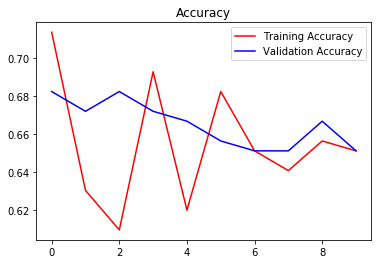

<Figure size 432x288 with 0 Axes>

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

n_epochs = range(len(acc))

plt.plot(n_epochs, acc, 'r', label='Training Accuracy')
plt.plot(n_epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

### Saving the Trained Model

In [23]:
name = 'Mobile-red-only'
model.save(f'{name}.h5')
model.save_weights(f'{name}-weights.h5')

In [13]:
model.load_weights('Mobile-epochs-4-weights.h5')

### Testing the Model

In [16]:
model.evaluate_generator(train_generator, verbose=2)

28/28 - 21s - loss: 0.7021 - accuracy: 0.6293


[0.7021000874894006, 0.62929064]

In [17]:
model.evaluate_generator(validation_generator, verbose=2)

7/7 - 2s - loss: 0.7598 - accuracy: 0.6164


[0.7597885302134922, 0.6164383]

In [43]:
train_generator.reset()
preds = model.predict(train_generator, verbose=1)
preds = np.argmax(preds, axis=1)
print(classification_report(train_generator.classes, preds))

35/35 [==============================] - 26s 730ms/step
              precision    recall  f1-score   support

           0       0.62      1.00      0.77       545
           1       0.00      0.00      0.00       329

    accuracy                           0.62       874
   macro avg       0.31      0.50      0.38       874
weighted avg       0.39      0.62      0.48       874



In [14]:
validation_generator.reset()
preds = model.predict(validation_generator, verbose=1)
preds = np.argmax(preds, axis=1)
print(classification_report(validation_generator.classes, preds))

7/7 [==============================] - 10s 1s/step
              precision    recall  f1-score   support

           0       0.59      1.00      0.74       130
           1       0.00      0.00      0.00        89

    accuracy                           0.59       219
   macro avg       0.30      0.50      0.37       219
weighted avg       0.35      0.59      0.44       219



C:\ProgramData\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
